# Median Flow

This topic is based almost entirely on the 2010 paper by Kalal, Mikolajczyk, and Matas, "Forward-Backward Error: Automatic Detection of Tracking Failures". The paper is available in the files section of Canvas.

## Overview

- There are many algorithms for object tracking
- Median Flow is a simple and effective algorithm that builds on the Lucas-Kanade method
- It is a good choice for many applications, including tracking objects in video

## Object Tracking vs. Optical Flow

- Object tracking is the process of locating a moving object over time
- Optical flow is lower level
    - It represents the tracking of pixels between frames
    - We can think of it as tracking the "corners", features, or "keypoints" that we discusssed earlier
    - Sometimes this is called __point tracking__
- Optical flow is used by many object tracking algorithms, including Median Flow


## Introduction

- __Point tracking__
    - We have a point location at time $t$ (perhaps from a corner detector)
    - We want to find the location of the point at time $t+1$
- Tracking Failure Causes
    - Points may change appearance (e.g., the patch may start to look different, such as during an eye blink)
    - Points may move out of the frame
    - Points may be occulded
    - Points may move too far between frames
- Tracking Failure Detection Goals
    - We want to detect when tracking fails
    - This is important because we don't want to use bad data
    - We want to be able to re-initialize tracking when it fails
    - We want to be able to detect when the object is lost
- __Forward-backward error__
    - They propose a new method for detecting tracking failures
    - It is based on the idea of comparing the forward and backward tracking errors
    - First, the forward trajectory is computed (for each point)
    - Second, the backward trajectory is computed
    - Third, the trajectories are compared
        - If differ significantly, tracking has failed
- See Figure 1 in the article

## Error Measures
- Sum of square differences (SSD)
    - Applied to a patch compared from $t$ and $t+1$
    - Advantages
        - Detects failures caused by occlusion and rapid movements
    - Disadvantages
        - Does not detect slowly drifting trajectories

## Forward-Backward (FB) Error

- Suppose we have a sequence of frames $I_t$, $I_{t+1}$, $I_{t+2}$, ..., $I_{t+k}$
- Let $x_t$ be a point in frame $I_t$ at time $t$
- Use some tracker to track $x_t$ forward for $k$ frames
- This gives us a trajectory $x_t$, $x_{t+1}$, ..., $x_{t+k}$
- The resulting trajectory is $T_f = \{x_t, x_{t+1}, ..., x_{t+k}\}$
    - Called the __forward trajectory__
- Now, track $x_{t+k}$ backward to $x_t$
- This gives us a trajectory $x_{t+k}$, $x_{t+k-1}$, ..., $x_t$
- The resulting trajectory is $T_b = \{\hat{x}_t, \hat{x}_{t+1}, ..., \hat{x}_{t+k}\}$ where $\hat{x}_t = x_{t+k}$
    - Called the __backward trajectory__
- The __forward-backward error__ is some measure of distance between $T_f$ and $T_b$
    - Various distance measures can be used
    - They proposed simply the Euclidean distance between the initial point of $T_f$ and the final point of $T_b$: $\|x_t - \hat{x}_t\|$
- Note the FB error can be applied to many different point tracking algorithms
- Also easy to implement


## Detection of Tracking Failures

- They evaluated the FB error on a large dataset
- Synthetic data
- One hundred images
- Warped with a random affine transform, and added Gaussian noise
    - Few details on the images
    - No examples, or links
    - Size, grayscale, etc. not given
- Initialized a set of points on a grid
    - No rationale given, but tried something else later
    - 5 pixel interval
    - Placed on the original image, then projected onto warped images
    - Established a ground truth
- Used the Lucas-Kanade tracker
    - Displacements that were closer than 2 pixels were labeled as inliers
    - 65% of the points were inliers
- They computed the FB error for each point
    - If error was less than a threshold, declared as an inlier
- This is a detection problem
    - Trying to use an algorithm to determine which points are true inliers
    - Used precision-recall curves to examine tradeoff
        - Precision: fraction of true inliers among all points declared as inliers
        - Recall: fraction of declared inliers that were true inliers
    - These will be familiar ideas for those of you taking the estimation and detection class
- With a threshold of 1 pixel
    - Recall: 95%
    - Precision: 96%
- Compared FB to SSD
    - FB was much better
- They also tried using the "FAST" feature point detector
    - Informally mentioned they had "consistent observations"


## Trajectory Selection

- Tracking is sensitive to intialization
- Typically done with a "corner" detector applied to the first frame
    - SIFT, Harris, FAST, etc.
- Problems
    - These might become occluded
    - Might disappear
    - Might change appearance
- If possible, selection of features to track should include whole video
- They used a "brute force" method
    - Track every pixel from first frame through whole sequence
    - Evaluate based on FB error
    - Assign each pixel the error of its trajectory
- Can create an image from this that they called an _error map_
    - Each pixel in the error map is the FB error of the trajectory that passes through that pixel
    - This is a way to visualize the error
- Approach: pick the pixels with the lowest error

## Median Flow

- They are best known for an object tracking algorithm called __Median Flow__
- Based on the earlier ideas discussed for feature tracking
- But how do we go from feature tracking to object tracking?
- Algorithm accepts a bounding box around the object and a pair of images
- Output is a new bounding box around the object in the second image
    - Point Cloud Tracking
        - Initialize a set of points ona rectangular grid inside the first bounding box
        - Track with Lucas-Kanade tracker to next frame
        - Measure the quality of the point predictions using some measure of error (FB, NCC, SSD, etc.)
        - Discard 50% of the points with the highest error (this is the "median" part)
        - Remaining predictions used to estimate displacement of the box
    - Box Estimation
        - Calculate median displacement of the tracked points
        - Update box location (translation only) using this displacement
        - Scale the box based on the median scale change of the tracked point pair distances
        - Update the box size
    - Repeat
- Very brief descriptions with little rationale and some ambiguity
    - Do they look at all possible pairs of points? This would be $O(n^2)$ if there are $n$ points
    - Why use 50% of points
    - How do they calculate the median displacement?




## Performance

- They compared some variants of the algorithm based on different error measures
- Best performer used two criteria
    - Throw out 50% of points with largest FB error
    - Throw out 50% of points with largest NCC error
- Compared to other published "state of the art" trackers
- Declared tracking to be correct if bounding box overlap with ground truth was larger than 50%
- Performance assessed as maximal frame number up to which tracker was correct
- Used 6 video sequences from another publication

In [2]:
import cv2 as cv
import sys
import os
import matplotlib.pyplot as plt


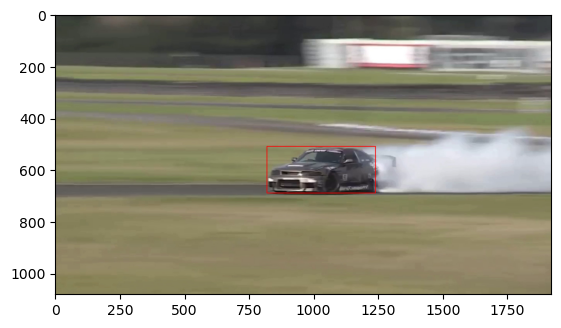

In [7]:
video_input_filename = os.path.join('videos', 'race_car.mp4')
video_output_filename = os.path.join('videos', 'race_car_output.mp4')

cap = cv.VideoCapture(cv.samples.findFile(video_input_filename))

# Read first frame from video and convert from BGR to RGB.
ret, frame = cap.read()
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

# Confirm video file can be opened.
if not cap.isOpened():
    print("Error: Could not open video.")
    sys.exit()
    
# Get video properties.
width  = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv.CAP_PROP_FPS)
    
fps_write = 20    # slow down video for demonstration purposes.

# Set up video writer for mp4.
fourcc = cv.VideoWriter_fourcc(*'mp4v')

# Create video writer object.
video_out = cv.VideoWriter( video_output_filename, fourcc, fps_write, (width, height) )

# Define a bounding box for the location of the object in the first video frame.
bbox = (820, 510, 420, 180) # race car

# Draw bounding box on frame and display it
frame_copy = frame.copy()  # make a copy of the frame
p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv.rectangle(frame_copy, p1, p2, (255,0,0), 2, 1)

figure = plt.figure()
plt.imshow(frame_copy)


In [8]:

tracker = cv.legacy_TrackerMedianFlow.create()

# Initialize tracker with first frame and bounding box
ok = tracker.init(frame, bbox)

# Loop through video frames
while True:
    # Read a new frame
    ret, frame = cap.read()
    if not ret:
        break

    # Update tracker
    ok, bbox = tracker.update(frame)

    # Draw bounding box
    if ok:
        # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv.rectangle(frame, p1, p2, (255,0,0), 2, 1)
    else:
        # Tracking failure
        cv.putText(frame, "Tracking failure detected", (100,80), cv.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)

    # Display result
    cv.imshow("Tracking", frame)

    # Write frame to output video
    video_out.write(frame)

    # Exit if ESC pressed
    k = cv.waitKey(1) & 0xff
    if k == 27 : break

# Release video capture and writer
cap.release()
video_out.release()
cv.destroyAllWindows()
cv.waitKey(1)

-1